In [1]:
import gzip
from Bio import SeqIO, SeqRecord
from Bio.SeqUtils import CodonAdaptationIndex
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import entropy
import numpy as np
import re
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime
import random
from collections import Counter

human_proteome_path = "../../datasets/raw/Homo_sapiens.GRCh38.cds.all.fa.gz"
# base_path = "../../datasets/raw/spikenuc0415_clean_n_X.fasta"
# base_path = "../../datasets/raw/spike_nuc_clean_3813"
base_path = "../../datasets/raw/spike_nuc_X.fasta.gz"
de_novo_path = "../../sample_outputs/2023_06_28__13_17_41/rnaformer_base__generated__de_novo.fasta"
de_novo_human_path = "../../sample_outputs/2023_06_28__13_31_04/rnaformer_base_human_cai__generated__de_novo.fasta"
de_novo_covid_path = "../../sample_outputs/2023_07_21__16_28_20/rnaformer_large_covid_cai__generated__de_novo.fasta"

covid_3813_path = "../../datasets/spike_nuc_clean_3813.fasta"
paths = []

pattern = re.compile("[^AatTgGcC*?]")

for i in range(0, 15):
    path = base_path.replace("X", str(i+1))
    paths.append(path)

def is_gene_valid(seq):
    if len(seq) % 3 != 0:
        return False
    if re.search(pattern, str(seq)):
        return False
    
    return True

CODON_INDICES = {
    "AAA": 0,
    "AAC": 1,
    "AAG": 2,
    "AAT": 3,

    "ACA": 4,
    "ACC": 5,
    "ACG": 6,
    "ACT": 7,
 
    "AGA": 8,
    "AGC": 9,
    "AGG": 10,
    "AGT": 11,
 
    "ATA": 12,
    "ATC": 13,
    "ATG": 14,
    "ATT": 15,
 
    "CAA": 16,
    "CAC": 17,
    "CAG": 18,
    "CAT": 19,

    "CCA": 20,
    "CCC": 21,
    "CCG": 22,
    "CCT": 23,
 
    "CGA": 24,
    "CGC": 25,
    "CGG": 26,
    "CGT": 27,
 
    "CTA": 28,
    "CTC": 29,
    "CTG": 30,
    "CTT": 31,

    "GAA": 32,
    "GAC": 33,
    "GAG": 34,
    "GAT": 35,

    "GCA": 36,
    "GCC": 37,
    "GCG": 38,
    "GCT": 39,
 
    "GGA": 40,
    "GGC": 41,
    "GGG": 42,
    "GGT": 43,
 
    "GTA": 44,
    "GTC": 45,
    "GTG": 46,
    "GTT": 47,

    "TAA": 48,
    "TAC": 49,
    "TAG": 50,
    "TAT": 51,

    "TCA": 52,
    "TCC": 53,
    "TCG": 54,
    "TCT": 55,
 
    "TGA": 56,
    "TGC": 57,
    "TGG": 58,
    "TGT": 59,
 
    "TTA": 60,
    "TTC": 61,
    "TTG": 62,
    "TTT": 63,
}

# Start Codon Usage

In [65]:
## Check if all sequences start with ATG
wrong_start_codon_de_novo = 0
wrong_start_codon_natural = 0

# Natural sequences
# for path in paths:
#     all = []
#     i = 0
#     with gzip.open(path, "rt") as handle:
#         for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
#             if is_gene_valid(seq_record.seq):
#                 triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

#                 if triplets[0] != "ATG":
#                     wrong_start_codon_natural += 1
#                 i+=1
#             if i > 5000:
#                 break
#     # break
# Synthetic sequences
covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets[0] != "ATG":
            wrong_start_codon_natural += 1

print(wrong_start_codon_natural)

# Synthetic sequences
de_novo_seqs_file = SeqIO.parse(de_novo_path, "fasta")
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets[0] != "ATG":
            wrong_start_codon_de_novo += 1

print(wrong_start_codon_de_novo)

31647it [00:23, 1372.25it/s]


KeyboardInterrupt: 

In [49]:
## Check number of ATG codons

# Natural sequences
# covid_biases = []
# covid_start_codons = {}
# for path in paths:
#     all = []
#     i = 0
#     with gzip.open(path, "rt") as handle:
#         for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
#             if is_gene_valid(seq_record.seq):
#                 triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

#                 if triplets.count("ATG") in covid_start_codons:
#                     covid_start_codons[triplets.count("ATG")] += 1
#                 else:
#                     covid_start_codons[triplets.count("ATG")] = 1
#                 i+=1
#             if i > 5000:
#                 break
    # break
covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
covid_biases = []
covid_start_codons = {}
covid_start_codon_locs = np.zeros(3813)
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets.count("ATG") in covid_start_codons:
            covid_start_codons[triplets.count("ATG")] += 1
        else:
            covid_start_codons[triplets.count("ATG")] = 1

        for i ,e in enumerate(triplets):
            if e == 'ATG':
                covid_start_codon_locs[i] += 1
            
print(covid_start_codon_locs)

# Synthetic sequences
de_novo_seqs_file = SeqIO.parse(de_novo_path, "fasta")
de_novo_biases = []
de_novo_start_codons = {}
de_novo_start_codon_locs = np.zeros(3813)
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets.count("ATG") in de_novo_start_codons:
            de_novo_start_codons[triplets.count("ATG")] += 1
        else:
            de_novo_start_codons[triplets.count("ATG")] = 1
        
        for i ,e in enumerate(triplets):
            if e == 'ATG':
                de_novo_start_codon_locs[i] += 1

covid_df = pd.DataFrame.from_dict(covid_start_codons.items()).sort_values(0).set_index(0).rename(columns={1: "vals"})
print(covid_df)
de_novo_df = pd.DataFrame.from_dict(de_novo_start_codons.items()).sort_values(0).set_index(0).rename(columns={1: "vals"})
print(de_novo_df)

# Get max key to create bins for hisogram
max_key = np.max(list((de_novo_start_codons | covid_start_codons).keys()))
# print(max_key)
df_empty = pd.DataFrame({"vals":np.zeros(max_key+1)})
df_empty["vals"] = (df_empty["vals"] + de_novo_df["vals"]).fillna(0)
de_novo_df = df_empty
# print(list(de_novo_df["vals"]))

df_empty = pd.DataFrame({"vals":np.zeros(max_key+1)})
df_empty["vals"] = (df_empty["vals"] + covid_df["vals"]).fillna(0)
covid_df = df_empty
# print(covid_df["vals"])

bins = np.linspace(0, max_key, max_key+1)
# print(bins)
plt.bar(bins, de_novo_df["vals"]/np.sum(de_novo_df["vals"]) ,alpha=0.5, label='synthetic')
plt.bar(bins, covid_df["vals"]/np.sum(covid_df["vals"]) ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Start Codon Distribution")
plt.show()

40339it [01:13, 550.53it/s]


KeyboardInterrupt: 

1270
[1. 0. 0. ... 0. 0. 0.]
[0.99865051 0.         0.         ... 0.         0.         0.        ]
[0.000e+00 1.000e+00 2.000e+00 ... 1.267e+03 1.268e+03 1.269e+03]


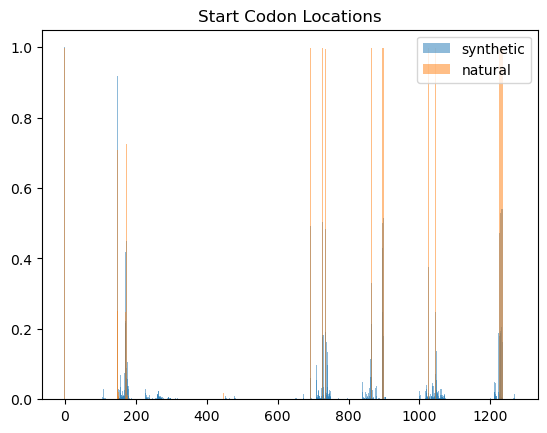

In [ ]:
# Find the last start codon
last_codon = max(np.max(np.nonzero(de_novo_start_codon_locs)), np.max(np.nonzero(covid_start_codon_locs)))
print(last_codon)
de_novo_start_codon_locs_short = de_novo_start_codon_locs[0:last_codon+1]
covid_start_codon_locs_short = covid_start_codon_locs[0:last_codon+1]

print(de_novo_start_codon_locs/np.sum(de_novo_df["vals"]))
print(covid_start_codon_locs/np.sum(covid_df["vals"]))

bins = np.linspace(0, last_codon, last_codon+1)
print(bins)
# print(bins)
plt.bar(bins, de_novo_start_codon_locs_short/np.sum(de_novo_df["vals"]), width=3 ,alpha=0.5, label='synthetic')
plt.bar(bins, covid_start_codon_locs_short/np.sum(covid_df["vals"]), width=3 ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Start Codon Locations")
plt.show()

# Stop Codon Usage

In [68]:
wrong_stop_codon_de_novo = 0
wrong_stop_codon_natural = 0

# Natural sequences
# for path in paths:
#     all = []
#     i = 0
#     with gzip.open(path, "rt") as handle:
#         for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
#             if is_gene_valid(seq_record.seq):
#                 triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

#                 if triplets[0] != "ATG":
#                     wrong_start_codon_natural += 1
#                 i+=1
#             if i > 5000:
#                 break
#     # break
# Synthetic sequences
# covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
# for seq_record in tqdm(covid_seqs_file):
#     if is_gene_valid(seq_record.seq):
#         triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

#         if triplets[len(triplets)-1] != 'TAG' and triplets[len(triplets)-1] != 'TAA' and triplets[len(triplets)-1] != 'TGA':
#             wrong_stop_codon_natural += 1

# print(wrong_stop_codon_natural)

# Synthetic sequences
de_novo_seqs_file = SeqIO.parse(de_novo_covid_path, "fasta")
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if 'TAG' in triplets[0 : len(triplets)-1] or 'TAA' in triplets[0 : len(triplets)-1] or 'TGA' in triplets[0 : len(triplets)-1]:
            wrong_stop_codon_de_novo += 1

        break

print(wrong_stop_codon_de_novo)

0it [00:00, ?it/s]

[Seq('ATG'), Seq('TTT'), Seq('GTT'), Seq('TTA'), Seq('TTG'), Seq('CCA'), Seq('CTA'), Seq('GTC'), Seq('TCT'), Seq('AGT'), Seq('CAG'), Seq('TGT'), Seq('GTT'), Seq('AAT'), Seq('CTT'), Seq('AAT'), Seq('CTT'), Seq('ACA'), Seq('ACC'), Seq('AGA'), Seq('ACT'), Seq('CAA'), Seq('TTA'), Seq('CCC'), Seq('CCT'), Seq('GCA'), Seq('TAC'), Seq('ACT'), Seq('AAT'), Seq('TCT'), Seq('TTC'), Seq('ACA'), Seq('CGT'), Seq('GGT'), Seq('GTT'), Seq('TAT'), Seq('TAC'), Seq('CCT'), Seq('GAC'), Seq('AAA'), Seq('GTT'), Seq('TTC'), Seq('AGA'), Seq('TCC'), Seq('TCA'), Seq('ACT'), Seq('TGG'), Seq('TTC'), Seq('CAT'), Seq('TCA'), Seq('ACT'), Seq('CAG'), Seq('GAC'), Seq('TTG'), Seq('TTC'), Seq('TTA'), Seq('CCT'), Seq('TTC'), Seq('TTT'), Seq('TCC'), Seq('AAT'), Seq('GTT'), Seq('ACT'), Seq('TGG'), Seq('TTC'), Seq('CAT'), Seq('GCT'), Seq('ATC'), Seq('TCT'), Seq('GGG'), Seq('ACC'), Seq('AAT'), Seq('GGT'), Seq('ACT'), Seq('AAG'), Seq('AGG'), Seq('TTT'), Seq('GAT'), Seq('AAC'), Seq('CCT'), Seq('GTC'), Seq('CTA'), Seq('CCA'), Seq

In [56]:
## Check number of ATG codons

# Natural sequences
# covid_biases = []
# covid_start_codons = {}
# for path in paths:
#     all = []
#     i = 0
#     with gzip.open(path, "rt") as handle:
#         for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
#             if is_gene_valid(seq_record.seq):
#                 triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

#                 if triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA") in covid_start_codons:
#                     covid_start_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] += 1
#                 else:
#                     covid_start_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] = 1
#                 i+=1
#             if i > 5000:
#                 break
    # break

covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
covid_biases = []
covid_stop_codons = {}
covid_stop_codon_locs = np.zeros(3813)
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA") in covid_stop_codons:
            covid_stop_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] += 1
        else:
            covid_stop_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] = 1

        for i ,e in enumerate(triplets):
            if e == 'TAG' or e == 'TAA' or e == 'TGA':
                covid_stop_codon_locs[i] += 1




# Synthetic sequences
de_novo_seqs_file = SeqIO.parse(de_novo_path, "fasta")
de_novo_biases = []
de_novo_stop_codons = {}
de_novo_stop_codon_locs = np.zeros(3813)
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]

        if triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA") in de_novo_stop_codons:
            de_novo_stop_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] += 1
        else:
            de_novo_stop_codons[triplets.count("TAG") + triplets.count("TAA") + triplets.count("TGA")] = 1

        for i ,e in enumerate(triplets):
            if e == 'TAG' or e == 'TAA' or e == 'TGA':
                de_novo_stop_codon_locs[i] += 1

covid_df = pd.DataFrame.from_dict(covid_stop_codons.items()).sort_values(0).set_index(0).rename(columns={1: "vals"})
print(covid_df)
de_novo_df = pd.DataFrame.from_dict(de_novo_stop_codons.items()).sort_values(0).set_index(0).rename(columns={1: "vals"})
print(de_novo_df)

# Get max key to create bins for hisogram
max_key = np.max(list((de_novo_stop_codons | covid_stop_codons).keys()))
# print(max_key)
df_empty = pd.DataFrame({"vals":np.zeros(max_key+1)})
df_empty["vals"] = (df_empty["vals"] + de_novo_df["vals"]).fillna(0)
de_novo_df = df_empty
# print(list(de_novo_df["vals"]))

df_empty = pd.DataFrame({"vals":np.zeros(max_key+1)})
df_empty["vals"] = (df_empty["vals"] + covid_df["vals"]).fillna(0)
covid_df = df_empty
# print(covid_df["vals"])

bins = np.linspace(0, max_key, max_key+1)
# print(bins)
plt.bar(bins, de_novo_df["vals"]/np.sum(de_novo_df["vals"]) ,alpha=0.5, label='synthetic')
plt.bar(bins, covid_df["vals"]/np.sum(covid_df["vals"]) ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Stop Codon Distribution")
plt.show()

2000it [00:06, 319.08it/s]


165832.0
965.0


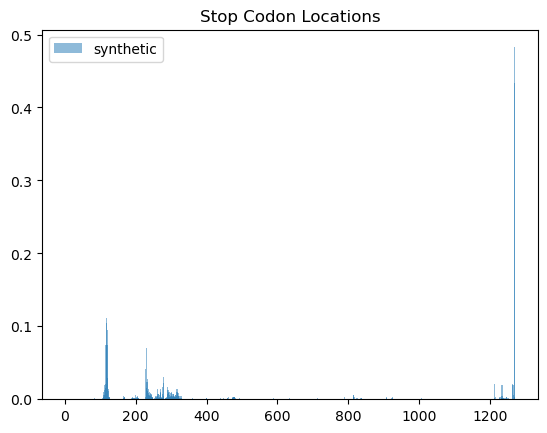

In [69]:
# Find the last start codon
print(covid_stop_codon_locs[1270])
print(de_novo_stop_codon_locs[1270])

last_codon = max(np.max(np.nonzero(de_novo_stop_codon_locs)), np.max(np.nonzero(covid_stop_codon_locs)))
# print(last_codon)
de_novo_stop_codon_locs_short = de_novo_stop_codon_locs[0:last_codon+1]
covid_stop_codon_locs_short = covid_stop_codon_locs[0:last_codon+1]

# print(de_novo_stop_codon_locs_short)
# print(covid_stop_codon_locs_short)

# print(de_novo_stop_codon_locs_short/np.sum(de_novo_df["vals"]))
# print(covid_stop_codon_locs_short/np.sum(covid_df["vals"]))

bins = np.linspace(0, last_codon, last_codon+1)
# print(bins)
# print(bins)
plt.bar(bins, de_novo_stop_codon_locs_short/np.sum(de_novo_df["vals"]), width=3 ,alpha=0.5, label='synthetic')
# plt.bar(bins, covid_stop_codon_locs_short/np.sum(covid_df["vals"]), width=3 ,alpha=0.5, label='natural')
plt.legend(loc='upper left')
plt.title("Stop Codon Locations")
plt.show()

# Shannon Entropy

10it [00:00, 11.58it/s]


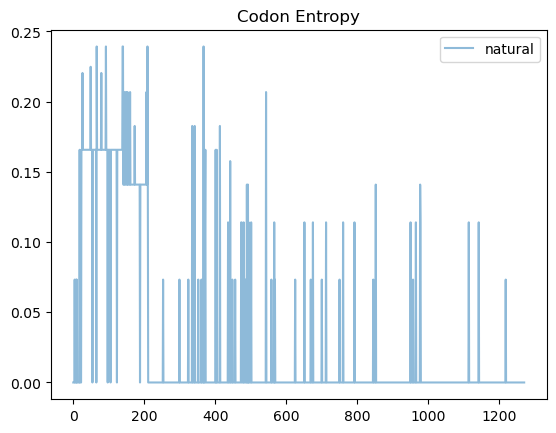

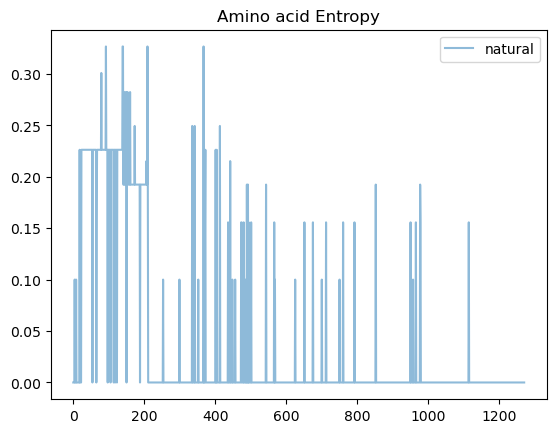

In [124]:
covid_seqs_file = SeqIO.parse(covid_3813_path, "fasta")
covid_df = pd.DataFrame(columns=range(0,1271))
covid_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        covid_df.loc[len(covid_df)] = triplets
        covid_protein_df.loc[len(covid_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        if i > 10:
            break


covid_df = covid_df.transpose()
entropies = []
# print(covid_df)
for _, row in covid_df.iterrows():
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    entropies.append(e)

plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy")
plt.show()

covid_protein_df = covid_protein_df.transpose()
protein_entropies = []
# print(covid_protein_df)
for _, row in covid_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)

    # print(counts)
    e = entropy(counts, base = 21)
    protein_entropies.append(e)

plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy")
plt.show()
# covid_entropy = entropy(covid_protein_df)
# print(covid_entropy)

1000it [01:59,  8.37it/s]


           0          1          2          3          4          5     \
0     (A, T, G)  (A, T, G)  (A, T, G)  (A, T, G)  (A, T, G)  (A, T, G)   
1     (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)   
2     (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)   
3     (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)  (T, T, T)   
4     (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)  (G, T, T)   
...         ...        ...        ...        ...        ...        ...   
1266  (C, A, T)  (T, T, A)  (C, A, T)  (T, T, A)  (C, A, T)  (A, A, G)   
1267  (T, A, C)  (C, A, T)  (T, A, C)  (C, A, T)  (T, A, C)  (G, T, G)   
1268  (A, C, A)  (T, A, C)  (A, C, A)  (T, A, C)  (A, C, A)  (A, A, A)   
1269  (T, A, A)  (A, C, A)  (T, A, A)  (A, C, A)  (T, A, A)  (T, C, A)   
1270  (A, C, G)  (T, A, A)  (A, C, G)  (T, A, A)  (A, C, G)  (C, T, C)   

           6          7          8          9     ...       991        992   \
0     (A, T, G)  (A, T, G)  (A, 

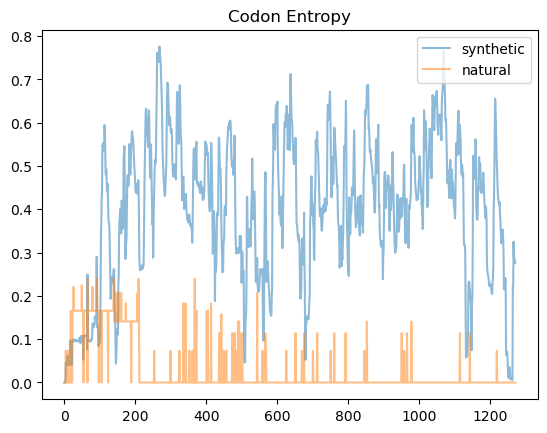

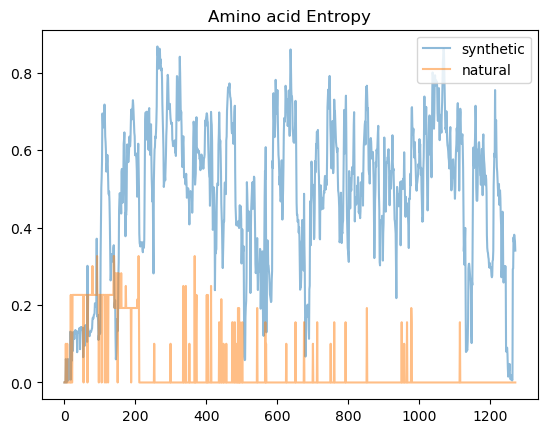

In [130]:
de_novo_seqs_file = SeqIO.parse(de_novo_path, "fasta")
de_novo_df = pd.DataFrame(columns=range(0,1271))
de_novo_protein_df = pd.DataFrame(columns=range(0,1271))
i = 0
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq) and len(seq_record.seq) == 3813:
        triplets = [seq_record.seq[i:i+3] for i in range(0, len(seq_record.seq), 3)]
        de_novo_df.loc[len(de_novo_df)] = triplets
        de_novo_protein_df.loc[len(de_novo_df)] = [*seq_record.seq.translate(to_stop=False)]
        i += 1
        if i > 1000:
            break


de_novo_df = de_novo_df.transpose()
de_novo_entropies = []
print(de_novo_df)
for _, row in de_novo_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 64)
    de_novo_entropies.append(e)

plt.plot(range(0,1271), de_novo_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Codon Entropy")
plt.show()
# covid_entropy = entropy(covid_df)
# print(covid_entropy)

de_novo_protein_df = de_novo_protein_df.transpose()
de_novo_protein_entropies = []
# print(de_novo_protein_df)
for _, row in de_novo_protein_df.iterrows():
    # print(row)
    counts = np.divide(list(Counter(row).values()), i)
    e = entropy(counts, base = 21)
    de_novo_protein_entropies.append(e)

plt.plot(range(0,1271), de_novo_protein_entropies ,alpha=0.5, label='synthetic')
plt.plot(range(0,1271), protein_entropies ,alpha=0.5, label='natural')
plt.legend(loc='upper right')
plt.title("Amino acid Entropy")
plt.show()

# Codon distance

88266it [02:09, 682.98it/s]
2001it [00:02, 689.92it/s]
/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


4.409334351852833
2.708590033015156


/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 33.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: >

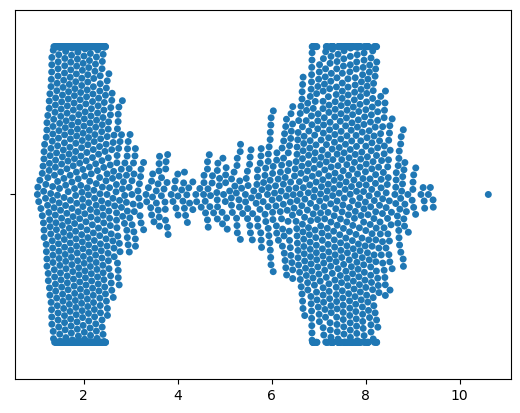

In [110]:
def genetic_distance(cai_1, cai_2):
    return abs(cai_1 - cai_2).sum() / 2

# Calculate the average (mean and std) CAI among the real samples
covid_CAIs = []
for seq_record in tqdm(covid_seqs_file):
    if is_gene_valid(seq_record.seq):
        covid_CAIs.append(list(CodonAdaptationIndex([seq_record.seq]).values()))

covid_CAI = np.mean(covid_CAIs, axis=0)
covid_CAI_std = np.std(covid_CAIs, axis=0)
# print(covid_CAI)
# print(covid_CAI_std)

# Calculate a vector of CAIs among the de novo sequences
de_novo_seqs_file = SeqIO.parse(de_novo_covid_path, "fasta")
de_novo_CAIs = []
for seq_record in tqdm(de_novo_seqs_file):
    if is_gene_valid(seq_record.seq):
        de_novo_CAIs.append(list(CodonAdaptationIndex([seq_record.seq]).values()))

# de_novo_CAI = np.mean(de_novo_CAIs, axis=0)
# de_novo_CAI_std = np.std(de_novo_CAIs, axis=0)
# print(de_novo_CAI)
# print(de_novo_CAI_std)

# Calculate the distance between the de novo CAIs and the template CAI
difs = []
for cai in de_novo_CAIs:
    difs.append(genetic_distance(cai, covid_CAI))
    
# Calculate mean distance and std
mean_dif = np.mean(difs)
dif_std = np.std(difs)
print(mean_dif)
print(dif_std)
# Plot the distribution

sns.swarmplot(difs, size=2.5)

/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

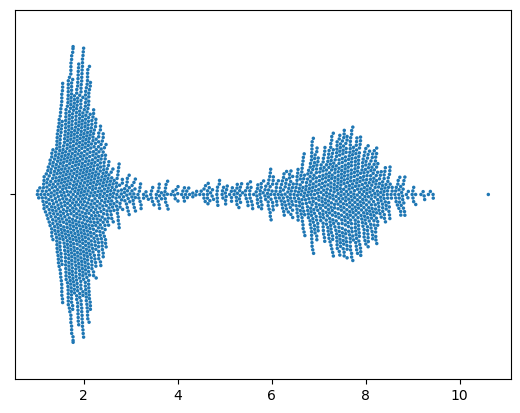